In [1]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from tqdm import tqdm

In [4]:
from scipy.interpolate import interp1d
from scipy.stats import rankdata
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import QuantileTransformer

In [5]:
from scipy import stats

def spearmanr(*args, **kwargs):
    return stats.spearmanr(*args, **kwargs).correlation

## Model implementation

In [6]:
def _value_at_rank(x, ranks):
    """Get value at ranks of multidimensional array."""
    assert x.shape[1] == ranks.shape[1]
    assert ranks.dtype == int
    n, m = ranks.shape
    y = np.zeros((n, m), dtype=float)
    for ii in range(m):
        y[:, ii] = np.take(x[:, ii], ranks[:, ii])
    return y

In [7]:
class MultiCAM_OG:
    def __init__(self, n_features: int, n_targets: int) -> None:
        assert isinstance(n_features, int) and n_features > 0
        self.n_features = n_features
        self.n_targets = n_targets
        self.trained = False 

        # additional metadata that needs to be saved for prediction.
        self.qt_xr = None
        self.qt_yr = None
        self.qt_x = None
        self.qt_y = None
        self.y_train = None
        self.x_train = None

        # setup linear regression model
        self.reg = linear_model.LinearRegression()


    def fit(self, x, y):
        """Fit model using training data"""
        assert np.sum(np.isnan(x)) == np.sum(np.isnan(y)) == 0
        assert x.shape == (y.shape[0], self.n_features)
        assert y.shape == (x.shape[0], self.n_targets)

        # need to save training data to predict from ranks later.
        self.x_train = x.copy()
        self.y_train = y.copy()

        # first get ranks of features and targets.
        xr = rankdata(x, axis=0, method="ordinal")
        yr = rankdata(y, axis=0, method="ordinal")

        # then get a quantile transformer for the ranks to a normal distribution.
        self.qt_xr = QuantileTransformer(n_quantiles=len(xr), output_distribution="normal")
        self.qt_xr = self.qt_xr.fit(xr)
        self.qt_yr = QuantileTransformer(n_quantiles=len(yr), output_distribution="normal")
        self.qt_yr = self.qt_yr.fit(yr)

        x_gauss, y_gauss = self.qt_xr.transform(xr), self.qt_yr.transform(yr)

        # then fit a linear regression model to the transformed data.
        self.reg.fit(x_gauss, y_gauss)
        
        self.trained = True

    def predict(self, x):
        assert len(x.shape) == 2
        assert x.shape[1] == self.n_features
        assert np.sum(np.isnan(x)) == 0
        assert self.trained

        # get ranks of test data.
        xr = rankdata(x, axis=0, method="ordinal")
        xr = (xr - 1) * (len(self.x_train) - 1) / (len(x) - 1) + 1
        
        # transform ranks to be (marginally) gaussian.
        xr_trans = self.qt_xr.transform(xr)

        # predict on transformed ranks.
        yr_trans = self.reg.predict(xr_trans)

        # get quantile transformer of prediction to (marginal) normal.
        qt_pred = QuantileTransformer(n_quantiles=len(yr_trans), output_distribution="normal")
        qt_pred.fit(yr_trans)

        # inverse transform prediction to get ranks of target.
        yr = self.qt_yr.inverse_transform(qt_pred.transform(yr_trans)).astype(int) - 1

        # predictions are points in train data corresponding to ranks predicted
        y_train_sorted = np.sort(self.y_train, axis=0)
        y_pred = _value_at_rank(y_train_sorted, yr)

        return y_pred

In [8]:
class MultiCAM:
    def __init__(self, n_features: int, n_targets: int) -> None:
        assert isinstance(n_features, int) and n_features > 0
        self.n_features = n_features
        self.n_targets = n_targets
        self.trained = False 

        # additional metadata that needs to be saved for prediction.
        self.qt_xr = None
        self.qt_yr = None
        self.qt_x = None
        self.qt_y = None
        self.y_train = None
        self.x_train = None
        self.qt_pred = None
        self.rank_lookup = {}

        # setup linear regression model
        self.reg = linear_model.LinearRegression()


    def fit(self, x, y):
        """Fit model using training data"""
        assert np.sum(np.isnan(x)) == np.sum(np.isnan(y)) == 0
        assert x.shape == (y.shape[0], self.n_features)
        assert y.shape == (x.shape[0], self.n_targets)

        # need to save training data to predict from ranks later.
        self.x_train = x.copy()
        self.y_train = y.copy()

        # first get ranks of features and targets.
        xr = rankdata(x, axis=0, method="ordinal")
        yr = rankdata(y, axis=0, method="ordinal")

        # then get a quantile transformer for the ranks to a normal distribution.
        self.qt_xr = QuantileTransformer(n_quantiles=len(xr), output_distribution="normal")
        self.qt_xr = self.qt_xr.fit(xr)
        self.qt_yr = QuantileTransformer(n_quantiles=len(yr), output_distribution="normal")
        self.qt_yr = self.qt_yr.fit(yr)

        x_gauss, y_gauss = self.qt_xr.transform(xr), self.qt_yr.transform(yr)

        # then fit a linear regression model to the transformed data.
        self.reg.fit(x_gauss, y_gauss)

        # get quantile transformer of prediction to (marginal) normal using training data.
        y_pred = self.reg.predict(x_gauss)
        self.qt_pred = QuantileTransformer(n_quantiles=len(y_pred), output_distribution="normal")
        self.qt_pred.fit(y_pred)

        # finally, create lookup table for low and high ranks of each feature.
        for jj in range(self.n_features):
            x_train_jj = np.sort(self.x_train[:, jj])
            u, c = np.unique(x_train_jj, return_counts=True)
            lranks = np.cumsum(c) - c + 1
            hranks = np.cumsum(c)
            self.rank_lookup[jj] = (u, lranks, hranks)

        
        self.trained = True

    @staticmethod
    def _value_at_rank(x, ranks):
        """Get value at ranks of multidimensional array."""
        assert x.shape[1] == ranks.shape[1]
        assert ranks.dtype == int
        n, m = ranks.shape
        y = np.zeros((n, m), dtype=float)
        for ii in range(m):
            y[:, ii] = np.take(x[:, ii], ranks[:, ii])
        return y

    def predict(self, x):
        assert len(x.shape) == 2
        assert x.shape[1] == self.n_features
        assert np.sum(np.isnan(x)) == 0
        assert self.trained

        # get ranks of test data (based on training data)
        xr = np.zeros_like(x) * np.nan
        for jj in range(self.n_features):
            x_jj = x[:, jj]
            x_train_jj = np.sort(self.x_train[:, jj])
            uniq, lranks, hranks = self.rank_lookup[jj]
            xr[:, jj] = np.searchsorted(x_train_jj, x_jj) + 1  # indices to ranks

            # if value is in training data, get uniform rank between low and high ranks.
            in_train = np.isin(x_jj, uniq)
            u_indices = np.searchsorted(uniq, x_jj[in_train])
            lr, hr = lranks[u_indices], hranks[u_indices]  # repeat appropriately
            # xr[in_train, jj] = np.random.randint(lr, hr + 1)
            # xr[in_train,jj] = lr
            xr[in_train, jj] = (lr + hr) / 2

        assert np.sum(np.isnan(xr)) == 0
        print('xr', xr[0,0])

        # transform ranks to be (marginally) gaussian.
        x_gauss = self.qt_xr.transform(xr)

        # predict on transformed ranks.
        y_not_gauss = self.reg.predict(x_gauss)

        # inverse transform prediction to get ranks of target.
        y_gauss = self.qt_pred.transform(y_not_gauss)
        yr = self.qt_yr.inverse_transform(y_gauss).astype(int)
        yr -= 1  # ranks are 1-indexed, so subtract 1 to get 0-indexed.

        # predictions are points in train data corresponding to ranks predicted
        y_train_sorted = np.sort(self.y_train, axis=0)
        y_pred = _value_at_rank(y_train_sorted, yr)

        return y_pred

## Real Dataset

In [9]:
from multicam.mah import get_mah

In [10]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [11]:
# catalog
cat = mah_data['cat']
cvir = cat['cvir']
ma = mah_data['ma']
ma_peak = mah_data['ma_peak']

indices = mah_data['indices']
scales = mah_data['scales']

### Illustration of repeated values with `ma_peak`

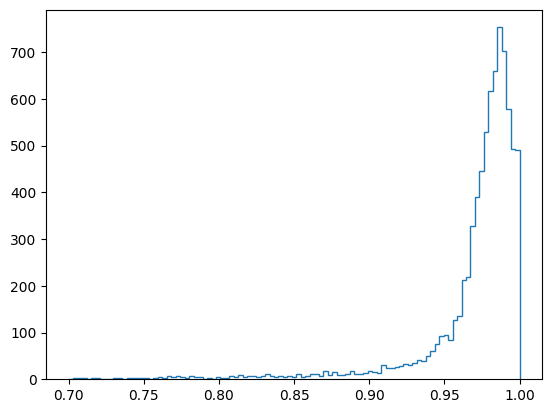

In [194]:
_ = plt.hist(ma[:, 150], bins=101, histtype='step', range=(0.7, 1), label='MA')

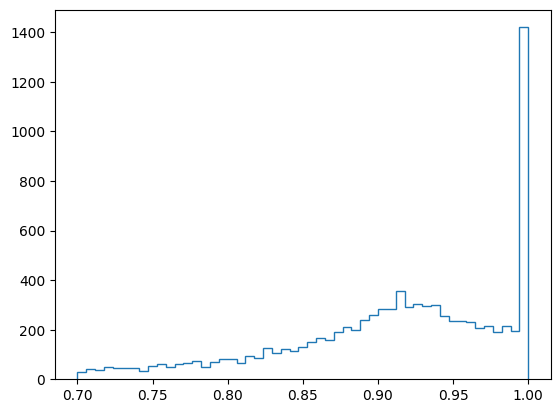

In [192]:
_ = plt.hist(ma_peak[:, 101], bins=51, histtype='step', range=(0.7, 1), label='MA peak')

### Predictions (with `ma`)

In [29]:
x = ma 
y = cvir[:, None]

In [30]:
model1 = MultiCAM_OG(n_features=165, n_targets=1)
model2 = MultiCAM(n_features=165, n_targets=1)

model1.fit(x, y)
model2.fit(x, y)

In [31]:
y_pred1 = model1.predict(x)
y_pred2 = model2.predict(x)

In [32]:
# significant correlation drop
spearmanr(y[:,0], y_pred1[:,0]), spearmanr(y, y_pred2[:,0])

(0.8032634746947371, 0.8033069077651853)

In [ ]:
# model1.predict(x[0, None, :]) # crashes with a single test point

In [33]:
model2.predict(x[0, None, :])[0,0], model2.predict(x)[0,0] # same

(7.24126672744751, 7.24126672744751)

**Takeaway**: Having no repeated values avoids both of the issues.

### Predictions (with `m_peak`)

Note that `ma_peak` has many more repeated values than `ma` especially for the late time features.

In [12]:
x = ma_peak 
y = cvir[:, None]

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [14]:
model1 = MultiCAM_OG(n_features=165, n_targets=1)
model2 = MultiCAM(n_features=165, n_targets=1)

model1.fit(x_train, y_train)
model2.fit(x_train, y_train)

In [247]:
# # shuffle 
# indices = np.random.choice(np.arange(len(x)), size=len(x), replace=False)
# x1 = x[indices]
# y1 = y[indices]

In [15]:
y_pred1 = model1.predict(x_test)
y_pred2 = model2.predict(x_test)

xr 1040.0


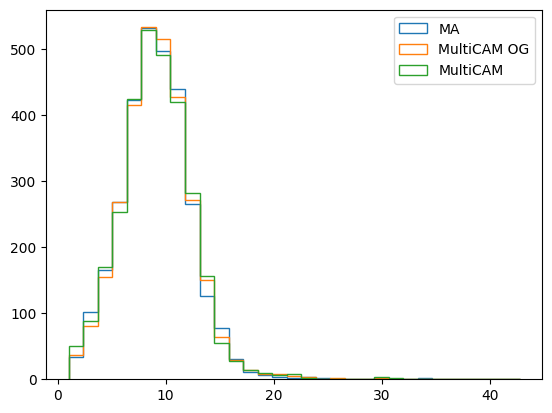

In [24]:
_, bins, _ = plt.hist(y_test[:,0], bins=31, histtype='step', label='MA')
_ = plt.hist(y_pred1[:,0], bins=bins, histtype='step', label='MultiCAM OG')
_ = plt.hist(y_pred2[:,0], bins=bins, histtype='step', label='MultiCAM')
plt.legend()


In [16]:
# significant correlation drop
spearmanr(y_test[:,0], y_pred1[:,0]), spearmanr(y_test[:,0], y_pred2[:,0])

(0.7943711992406189, 0.8002305183599041)

In [17]:
# significant correlation drop
spearmanr(y1[:,0], y_pred1[:,0]), spearmanr(y1[:,0], y_pred2[:,0])

NameError: name 'y1' is not defined

In [240]:
# model1.predict(x[0, None, :]) # crashes with a single test point

In [18]:
model1.predict(x)[0,0] # can very different.

8.955106735229492

In [19]:
model2.predict(x[0, None, :])[0,0], model2.predict(x)[0,0] # can very different.

xr 5001.0
xr 5001.0


(8.88155746459961, 8.88155746459961)

# Synthetic Dataset

In [60]:
np.median(x)

-2.0

In [222]:
# create synthetic dataset with repeated values in features.
np.random.seed(2)
n = 10_000
n_features = 10
n_targets = 1
x = np.random.randn(n, n_features)
for ii, c in enumerate(np.linspace(-1, 2, n_features)):
    x[x[:,ii] > c, ii] = c

# only subset of features matter
y = np.exp(np.arctan(x + 1)).sum(axis=1)[:,None] + np.random.randn(n, n_targets) * 0.5 

In [223]:
# # create synthetic dataset with repeated values in features.
# np.random.seed(0)
# n = 10_000
# n_features = 10
# n_targets = 1
# x = np.random.randn(n, n_features)
# for jj in range(n_features):
#     x[x[:,jj] > np.median(x[:,jj]), jj] = np.median(x[:,jj])
# # x[x > np.median(x)] = np.median(x)

# # only subset of features matter
# y = np.exp(np.arctan(x + 1)).sum(axis=1)[:,None] + np.random.randn(n, n_targets) * 0.5 

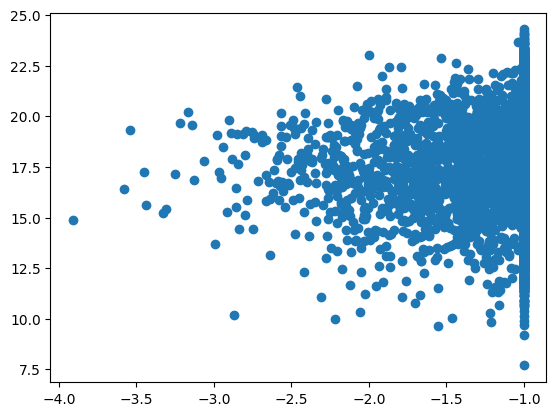

In [224]:
plt.plot(x[:,0], y[:,0], 'o')

# Prediction

In [225]:
np.random.seed(42)
model = MultiCAM(n_features, 1)
model.fit(x,y)


In [226]:
indices = np.random.choice(np.arange(n), size=n, replace=False)
x1 = x[indices]
y1 = y[indices]
x1 = x
y1 = y

In [227]:
y_pred = model.predict(x1)

xr 3358.0


In [228]:
model_og = MultiCAM_OG(n_features, 1)
model_og.fit(x,y)

In [229]:
y_pred_og = model_og.predict(x1)

In [230]:
# print(y_pred[:,0])
# print(y_pred_og[:,0])
# print(y1[:,0])
# print(x1[:,0])
print(spearmanr(y1[:,0], y_pred[:,0]), spearmanr(y1[:,0], y_pred_og[:,0]))

0.8947682449945787 0.8959947700998253


In [231]:
# idx = np.random.randint(0, len(x))
idx = 0
test_point = x[idx, None, :]
y1 = model.predict(test_point).item()
y2 = model.predict(x)[idx,0]
y1,y2

xr 9272.0
xr 2840.0


(11.978605837083926, 13.026020289258724)